In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestCentroid
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

### 2.1

In [28]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv", na_values = ' ')
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
4520,3506-LCJDC,Male,0,Yes,Yes,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Bank transfer (automatic),19.95,19.95,Yes
2261,3126-WQMGH,Female,0,Yes,No,49,Yes,Yes,DSL,No,...,No,No,No,No,Month-to-month,Yes,Credit card (automatic),52.15,2583.75,No
6469,7945-PRBVF,Male,0,No,No,35,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),21.45,705.45,No
1733,1015-OWJKI,Male,0,No,No,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.05,19.05,No
3499,0426-TIRNE,Female,0,No,No,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.90,20.90,Yes


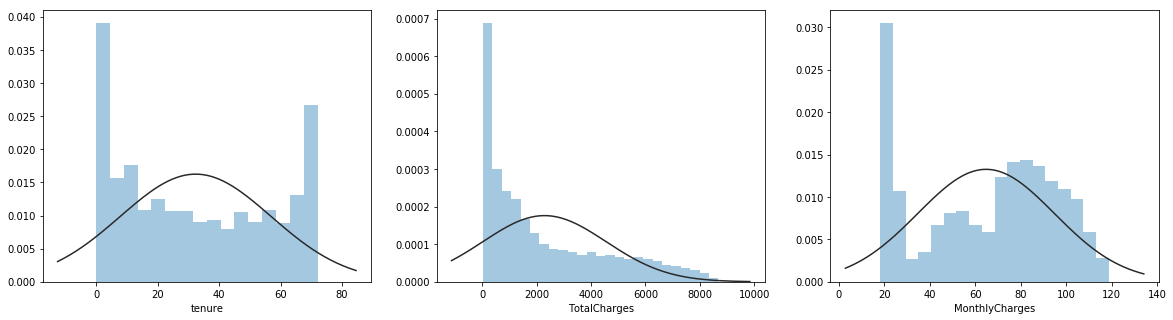

In [35]:
import seaborn as sns
from scipy.stats import norm
cont_data = ['tenure', 'TotalCharges', 'MonthlyCharges']
continuous_data = df[cont_data]
target = df['Churn']
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for col in range(3):
    sns.distplot(continuous_data[cont_data[col]][~pd.isna(continuous_data[cont_data[col]])],  ax = ax[col], fit=norm, kde=False)

### 2.2

### Without StandardScalar

In [40]:
x_data = df.iloc[:,df.columns!='Churn']

for i in list(x_data.columns):
    if x_data[i].dtype == 'object':
        x_data[i].fillna('others', inplace = True)
x_data.fillna(x_data.median(), inplace = True)
y_data = df['Churn']
y_data = y_data.map(dict(No=0, Yes=1))

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data)

discrete = X_train.dtypes == 'object'
col_trans = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse=False), discrete))

Logistic_pipe = make_pipeline(col_trans, LogisticRegression())
Logistic_fin = np.mean(cross_val_score(Logistic_pipe, X_train, y_train, cv=10))

SVM_pipe = make_pipeline(col_trans, LinearSVC())
SVM_fin = np.mean(cross_val_score(SVM_pipe, X_train, y_train, cv=10))

NN_pipe = make_pipeline(col_trans, NearestCentroid())
NN_fin = np.mean(cross_val_score(NN_pipe, X_train, y_train, cv=10))

In [41]:
print('Logistic: {:.2f}' .format(Logistic_fin))
print('SVM: {:.2f}'.format(SVM_fin))
print('KNN: {:.2f}'.format(NN_fin))

Logistic: 0.78
SVM: 0.79
KNN: 0.69


### With StandardScalar

In [48]:
col_trans = make_column_transformer((StandardScaler(), ~discrete), (OneHotEncoder(handle_unknown='ignore', sparse=False), discrete))
Logistic_pipe = make_pipeline(col_trans, LogisticRegression())
Logistic_fin = np.mean(cross_val_score(Logistic_pipe, X_train, y_train, cv=10))

SVM_pipe = make_pipeline(col_trans, LinearSVC())
SVM_fin = np.mean(cross_val_score(SVM_pipe, X_train, y_train, cv=10))

NN_pipe = make_pipeline(col_trans, NearestCentroid())
NN_fin = np.mean(cross_val_score(NN_pipe, X_train, y_train, cv=10))

In [49]:
print('Logistic: {:.2f}' .format(Logistic_fin))
print('SVM: {:.2f}'.format(SVM_fin))
print('KNN: {:.2f}'.format(NN_fin))

Logistic: 0.81
SVM: 0.81
KNN: 0.73


We notice the Standardizing effect improves the scores for all models

### 2.3

### Using Gridsearch

In [50]:
Logisticy = {'logisticregression__C': np.logspace(-3, 2, 6)}
SVMy = {'linearsvc__C': np.logspace(-3, 2, 6)}
knny = {'nearestcentroid__shrink_threshold': [None, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

Logistic_got = GridSearchCV(Logistic_pipe, Logisticy, cv=10)
SVM_got = GridSearchCV(SVM_pipe, SVMy, cv=10)
KNN_got = GridSearchCV(NN_pipe, knny, cv=10)

Logistic_got.fit(X_train, y_train)
SVM_got.fit(X_train, y_train)
KNN_got.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True), customerID          False
gender              False
SeniorCitizen...se
dtype: bool)])), ('nearestcentroid', NearestCentroid(metric='euclidean', shrink_threshold=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'nearestcentroid__shrink_threshold': [None, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [51]:
print('Logistic: {:.2f}' .format(Logistic_fin))
print('SVM: {:.2f}'.format(SVM_fin))
print('KNN: {:.2f}'.format(NN_fin))

Logistic: 0.81
SVM: 0.81
KNN: 0.73


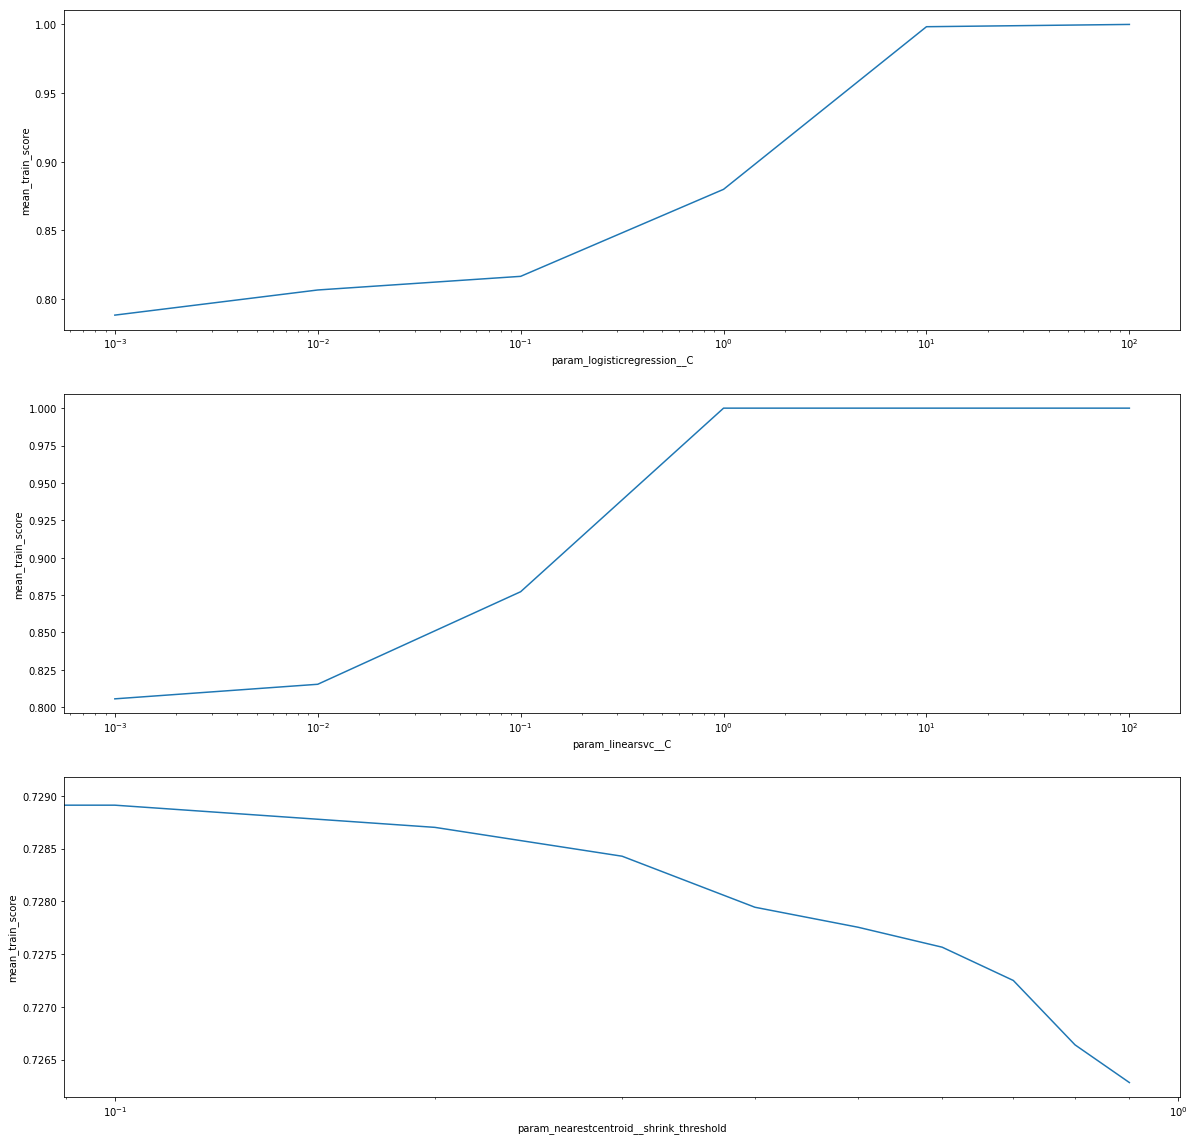

In [52]:
fig, ax = plt.subplots(3,1, figsize = (20, 20))
ax[0].plot(list(Logistic_got.cv_results_['param_logisticregression__C']), 
        list(Logistic_got.cv_results_['mean_train_score']))
ax[0].set_ylabel('mean_train_score')
ax[0].set_xlabel('param_logisticregression__C')
ax[0].set_xscale("log")

ax[1].plot(list(SVM_got.cv_results_['param_linearsvc__C']), 
      list(SVM_got.cv_results_['mean_train_score']))
ax[1].set_ylabel('mean_train_score')
ax[1].set_xlabel('param_linearsvc__C')
ax[1].set_xscale("log")

ax[2].plot(list(KNN_got.cv_results_['param_nearestcentroid__shrink_threshold']), 
      list(KNN_got.cv_results_['mean_train_score']))
ax[2].set_ylabel('mean_train_score')
ax[2].set_xlabel('param_nearestcentroid__shrink_threshold')
ax[2].set_xscale("log")

### 2.4

### With shuffling

In [54]:
from sklearn.model_selection import KFold
Logistic_kf = GridSearchCV(Logistic_pipe, Logisticy, cv=KFold(n_splits=3, shuffle=True))
Logistic_kf.fit(X_train, y_train)
SVM_kf = GridSearchCV(SVM_pipe, SVMy, cv=KFold(n_splits=3, shuffle=True))
SVM_kf.fit(X_train, y_train)
KNN_kf = GridSearchCV(NN_pipe, knny, cv=KFold(n_splits=3, shuffle=True))
KNN_kf.fit(X_train, y_train)


print('Logistic: {:.2f}'.format(Logistic_kf.best_score_))
print('SVM: {:.2f}'.format(SVM_kf.best_score_))
print('KNN: {:.2f}'.format(KNN_kf.best_score_))

Logistic: 0.80
SVM: 0.80
KNN: 0.73


Params dont change much here, almost same

### With random seed

In [55]:
Logistic_kfs = GridSearchCV(Logistic_pipe, Logisticy, cv=KFold(n_splits=3, random_state=7, shuffle=True))
Logistic_kfs.fit(X_train, y_train)
SVM_kfs = GridSearchCV(SVM_pipe, SVMy, cv=KFold(n_splits=3, random_state=7, shuffle=True))
SVM_kfs.fit(X_train, y_train)
KNN_kfs = GridSearchCV(NN_pipe, knny, cv=KFold(n_splits=3, random_state=7, shuffle=True))
KNN_kfs.fit(X_train, y_train)


print('Logistic: {:.2f}'.format(Logistic_kfs.best_score_))
print('SVM: {:.2f}'.format(SVM_kfs.best_score_))
print('KNN: {:.2f}'.format(KNN_kfs.best_score_))

Logistic: 0.80
SVM: 0.80
KNN: 0.73


Again, not much change!

### Changing the random seed of split of data

In [56]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, random_state = 1)

Logistic_kfx = GridSearchCV(Logistic_pipe, Logisticy, cv=KFold(n_splits=3, shuffle=True))
Logistic_kfx.fit(X_train, y_train)
SVM_kfx = GridSearchCV(SVM_pipe, SVMy, cv=KFold(n_splits=3, shuffle=True))
SVM_kfx.fit(X_train, y_train)
KNN_kfx = GridSearchCV(NN_pipe, knny, cv=KFold(n_splits=3, shuffle=True))
KNN_kfx.fit(X_train, y_train)


print('Logistic: {:.2f}'.format(Logistic_kfx.best_score_))
print('SVM: {:.2f}'.format(SVM_kfx.best_score_))
print('KNN: {:.2f}'.format(KNN_kfx.best_score_))

Logistic: 0.80
SVM: 0.80
KNN: 0.73


This again doesnt change the scores much! This shows us that we have stable models

### 2.5

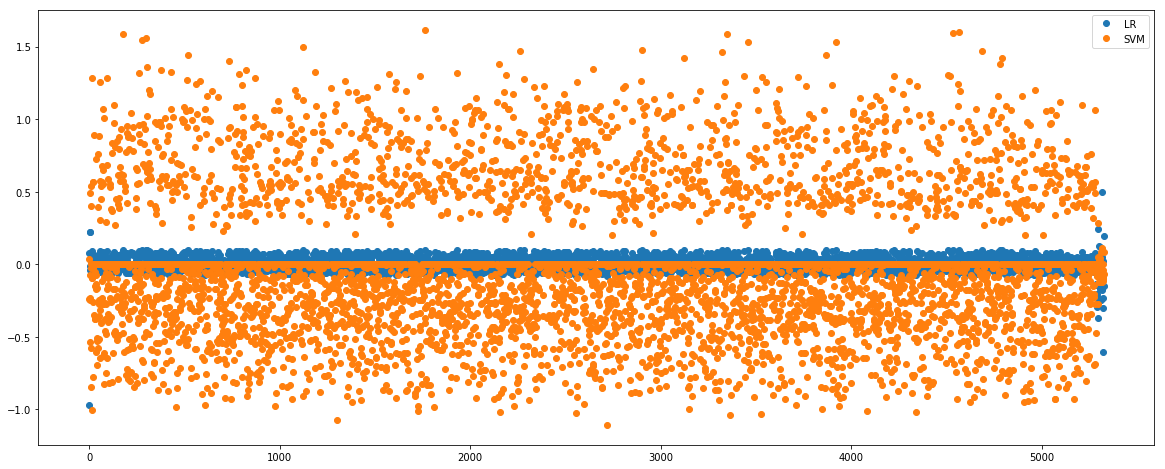

In [60]:
plt.figure(figsize=(20, 8))
plt.plot(Logistic_got.best_estimator_.named_steps['logisticregression'].coef_[0], 'o', label='LR')
plt.plot(SVM_got.best_estimator_.named_steps['linearsvc'].coef_[0], 'o', label='SVM')
plt.legend()